In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skipper import observe

import sys
sys.path.append('../scripts/')
import our_pointings
import sigjson_s2023a

In [4]:
#oiii_nights = obsdates[obsfilters == 'N540', :-1]
#halpha_nights = obsdates[obsfilters=='N708',:-1]

tele_fname = '/Users/kadofong/Downloads/tele20230515.csv'
copilot_fname = '/Users/kadofong/Downloads/db_merian.fits'



In [5]:
from ekfplot import plot as ek
from ekfplot import colors as ec

In [6]:
plt.rcParams['font.size'] = 16

In [7]:
clist = [ec.ColorBase('#347deb'), ec.ColorBase('#d1a515'), ec.ColorBase('#15d131'), ec.ColorBase('#d11528')]

In [9]:
oiii_pointings, halpha_pointings = our_pointings.load_springfields ()
coo_o = observe.CopilotOutput ( copilot_fname, oiii_pointings )
coo_h = observe.CopilotOutput ( copilot_fname, halpha_pointings )

Text(0.5, 0, 'MJD')

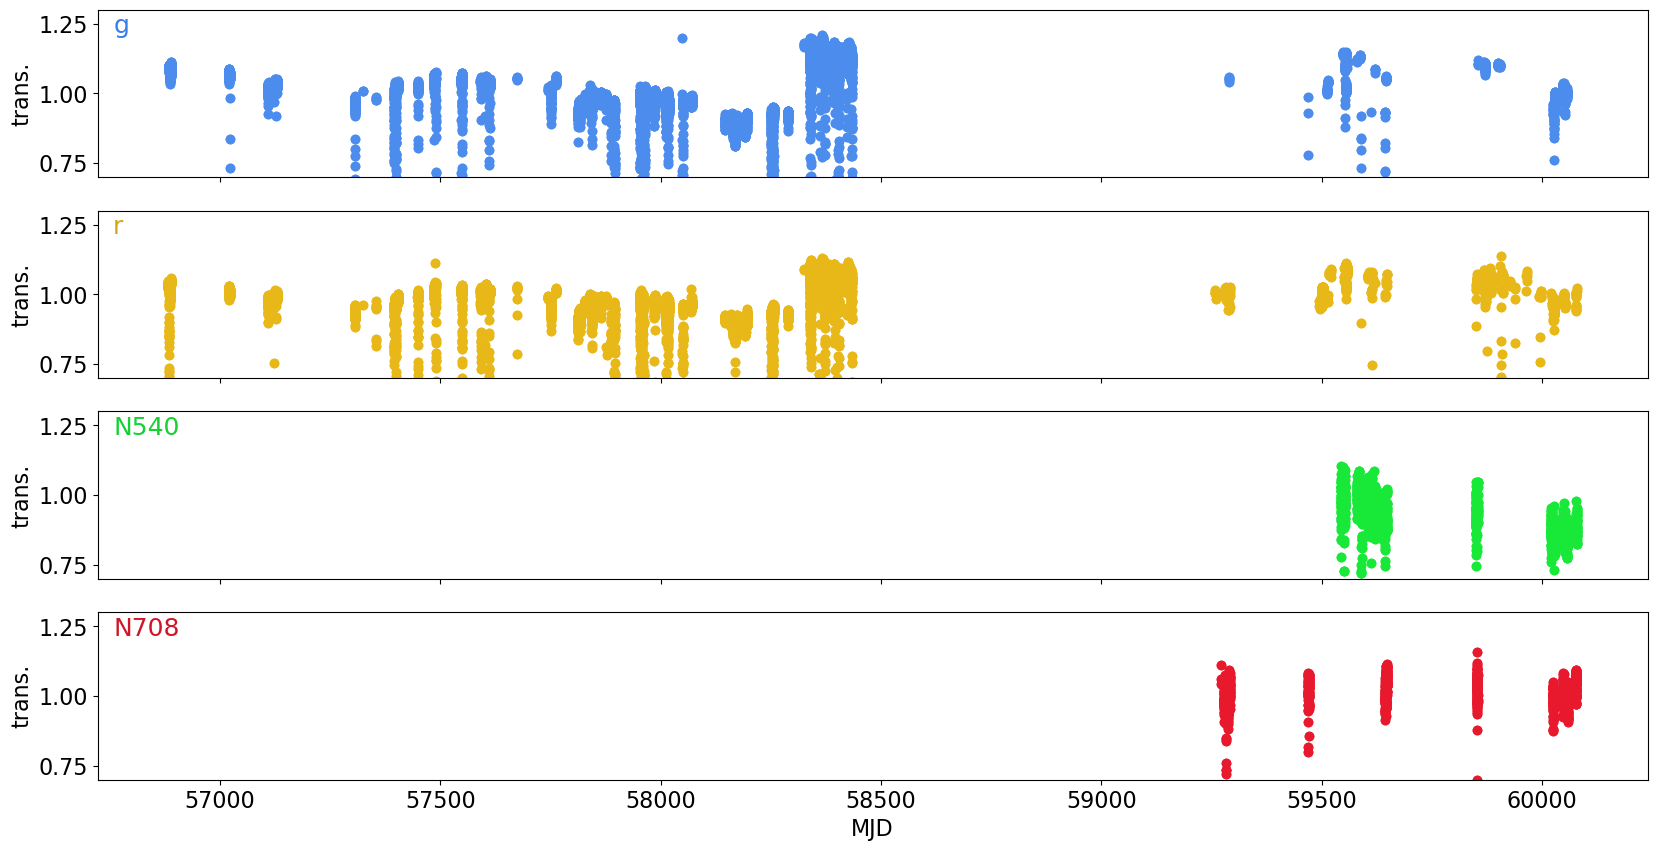

In [10]:
fig, axarr = plt.subplots(4,1,figsize=(20,10), sharex=True)
gmask = coo_o.sidecar['band'] == 'g'



for idx, band in enumerate(['g','r','N540','N708']):
    for coo in [coo_o,coo_h]:
        gmask = coo.sidecar['band'] == band
        axarr[idx].scatter ( coo.sidecar.loc[gmask,'mjd_obs'], 
                           coo.sidecar.loc[gmask,'transparency'],
                            color=clist[idx].modulate(0.05).base
                            )
    ek.text ( 0.01, 0.975, band, fontsize=18, color=clist[idx].base, ax=axarr[idx])
xlims = axarr[0].get_xlim()
for ax in axarr:
    ax.set_ylim(0.7,1.3)
    ax.set_xlim(xlims)
    ax.set_ylabel('trans.')
axarr[-1].set_xlabel('MJD')

#plt.xlim(56000, 61000)
#plt.xlim(coo_h.merian_sidecar['mjd_obs'].min(),coo_h.merian_sidecar['mjd_obs'].max())
#plt.savefig('/Users/kadofong/Downloads/transparency_vs_time_ZOOMOUT.png')

In [11]:
xmin = min(coo_h.merian_sidecar['mjd_obs'].min(),coo_o.merian_sidecar['mjd_obs'].min())
xmax = max(coo_h.merian_sidecar['mjd_obs'].max(),coo_o.merian_sidecar['mjd_obs'].max()) + 10

In [15]:
coo_d = {}

halpha_pointings, oiii_pointings =  our_pointings.load_springfields()
coo_d['sN540'] = observe.CopilotOutput ( copilot_fname, oiii_pointings )
coo_d['sN708'] = observe.CopilotOutput ( copilot_fname, halpha_pointings )

halpha_pointings, oiii_pointings =  our_pointings.load_fallfields()
coo_d['fN540'] = observe.CopilotOutput ( copilot_fname, oiii_pointings )
coo_d['fN708'] = observe.CopilotOutput ( copilot_fname, halpha_pointings )

In [20]:
teff_d = {'N540':300,'N708':200}

In [16]:
from matplotlib import patches

In [17]:
def wrap ( ra ):
    return np.where(ra>300., ra-360., ra)

In [18]:
fov_radius = (3.18/np.pi)**0.5
fov_area = 3.18

In [21]:
for ofilter in  ['N540', 'N708']:
    rough_coverage = 0.
    for season in ['fall','spring']:
        halpha_pointings, oiii_pointings =  getattr(our_pointings, f'load_{season}fields')()
        pointings_d = {'N540':oiii_pointings,'N708':halpha_pointings}  
        

        completed = coo_d[f'{season[0]}{ofilter}'].identify_completed_pointings ( teff_d[ofilter] )
        in_cosmos = completed['object'].apply ( lambda x: 'COSMOS' in x )
        print(f'N_cosmos={in_cosmos.sum()}')
        wide = completed.loc[~in_cosmos]
        teff_min = teff_d[ofilter]
        pointings = pointings_d[ofilter]   
        rcovered = (wide.shape[0])*fov_area/4.
        print(f'{season}; {ofilter}')
        print(completed.shape[0]/pointings.shape[0])
        print(rcovered)
        print('------')
        rough_coverage+= rcovered
    print(f'===>{ofilter}: {rough_coverage:.0f} sq. deg')

N_cosmos=0
fall; N540
0.34004024144869216
134.35500000000002
------
N_cosmos=40
spring; N540
0.8521505376344086
472.23
------
===>N540: 607 sq. deg
N_cosmos=0
fall; N708
0.2837022132796781
112.095
------
N_cosmos=40
spring; N708
0.8279569892473119
457.92
------
===>N708: 570 sq. deg


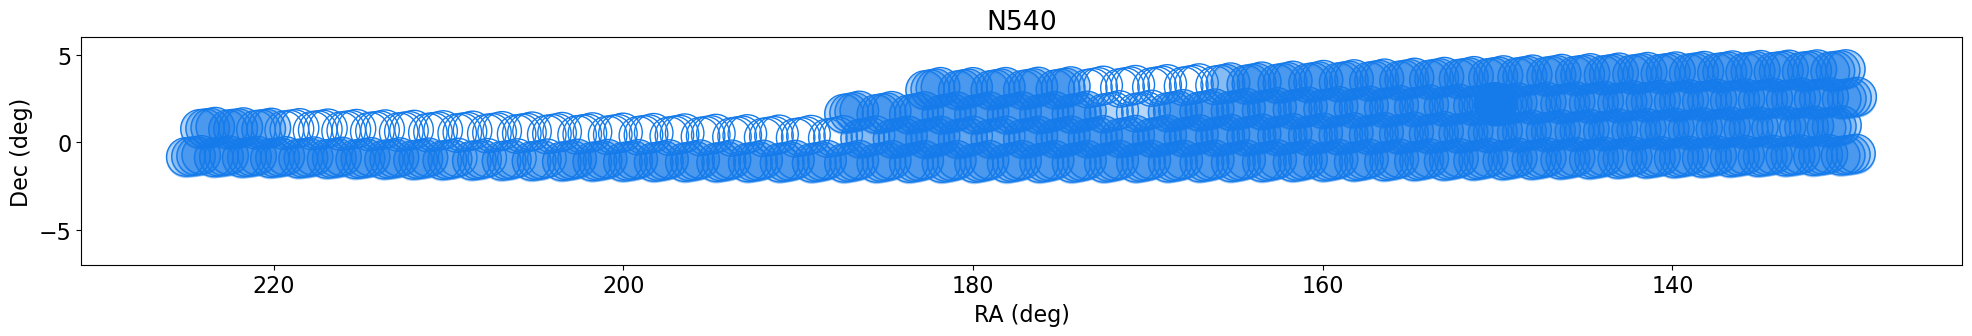

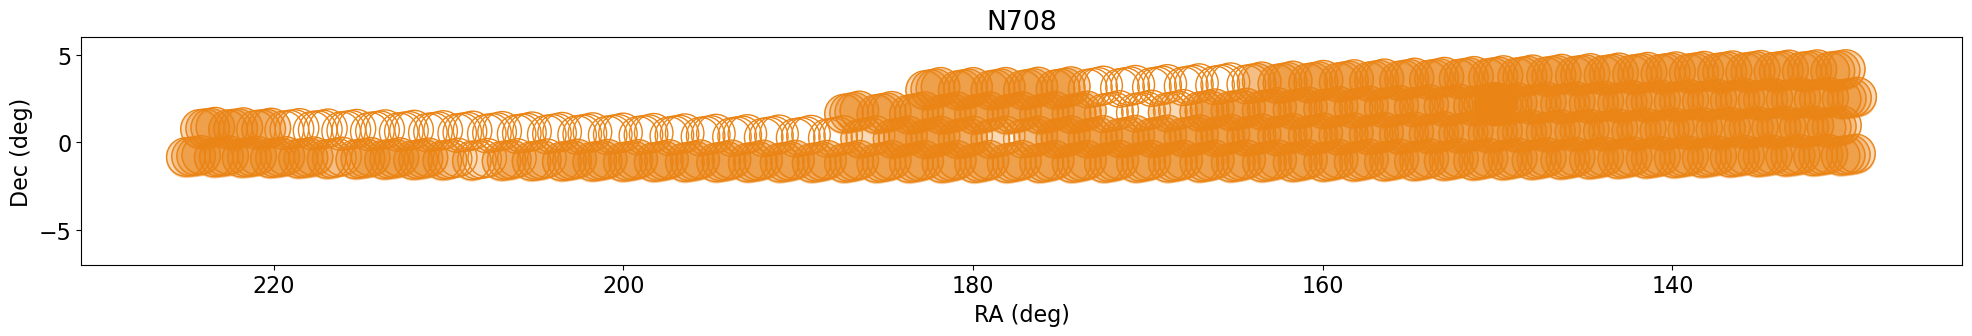

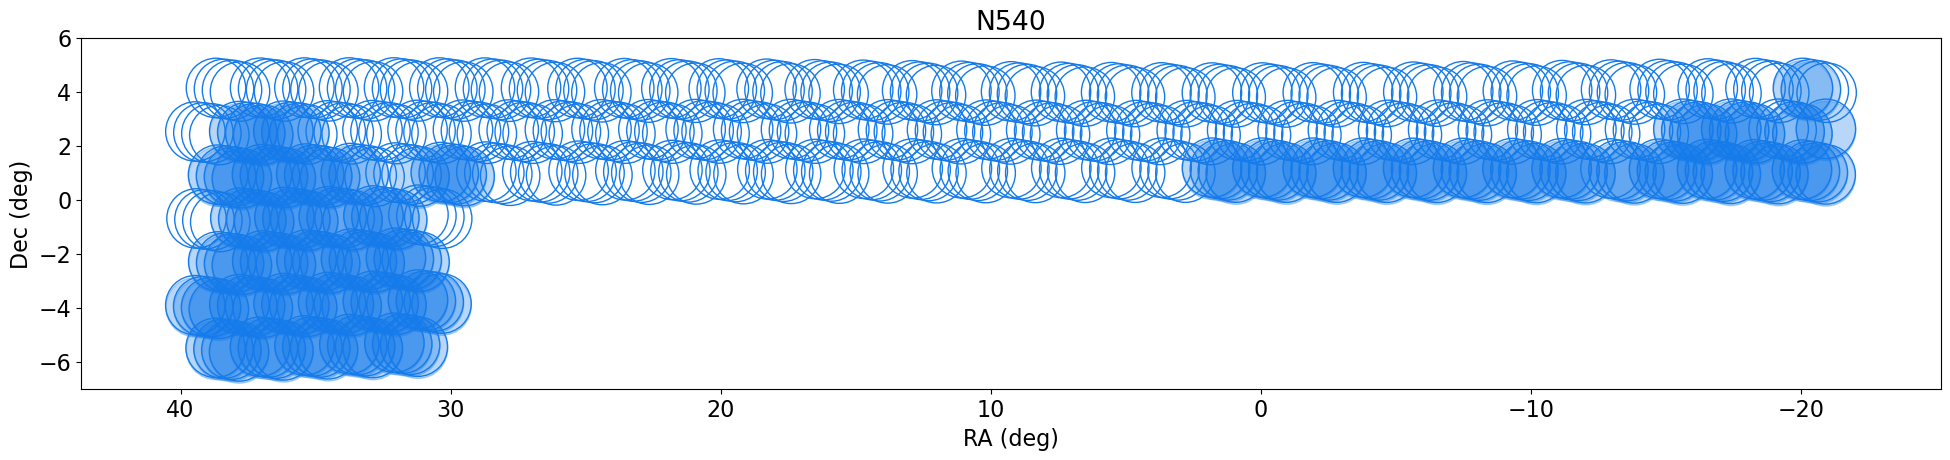

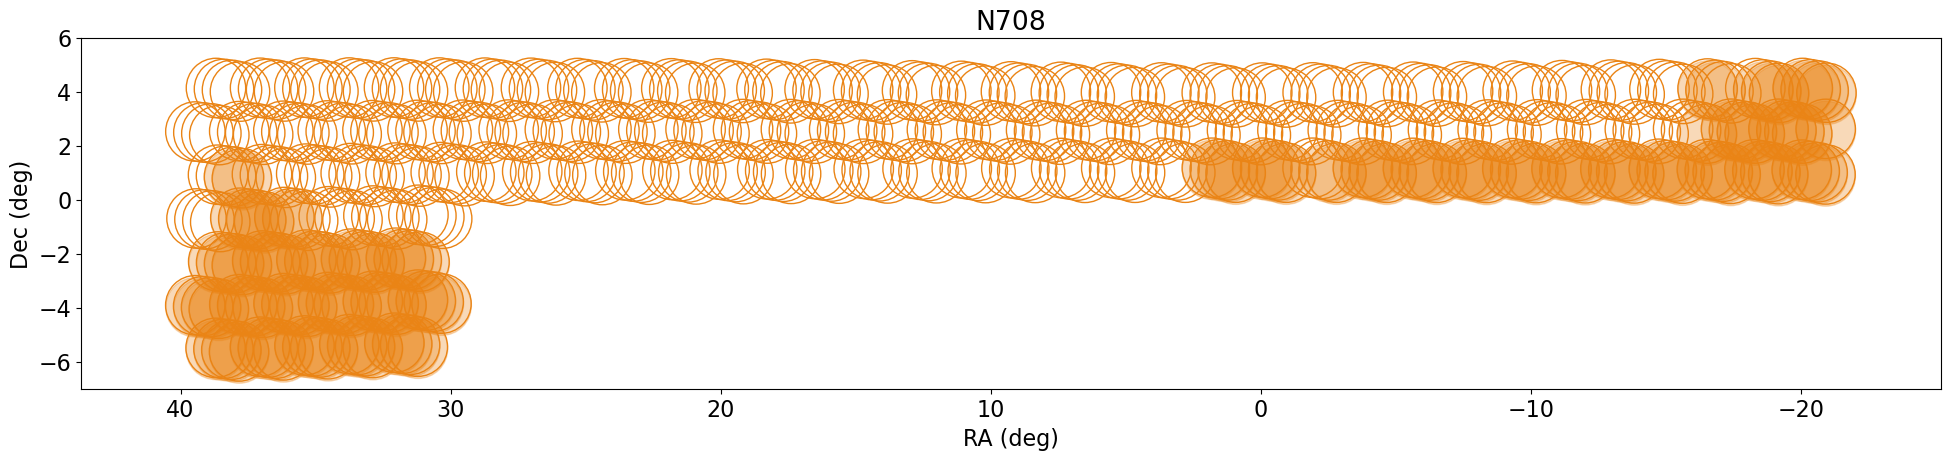

In [83]:
teff_d = {'N540':300, 'N708':200}
colors_d = {'N540':"#157BEA", "N708":"#EA8415"}


for season in ['spring','fall']:
    halpha_pointings, oiii_pointings =  getattr(our_pointings, f'load_{season}fields')()
    pointings_d = {'N540':oiii_pointings,'N708':halpha_pointings} 

    for ofilter in ['N540', 'N708']:
        teff_min = teff_d[ofilter]
        pointings = pointings_d[ofilter]
        completed = coo_d[f'{season[0]}{ofilter}'].identify_completed_pointings ( teff_min )


        fig, ax = plt.subplots(1,1, figsize=(20,5))
        ax.set_aspect('equal')

        ccolor = ec.ColorBase(colors_d[ofilter])
        for name,row in completed.iterrows ():
            circ = patches.Circle ( (wrap(row['racenter']), row['deccenter']),  radius=1.1, color=ccolor.base, alpha=0.3)
            ax.add_patch(circ)
        for name,row in pointings.iterrows ():
            circ = patches.Circle ( (wrap(row['RA']), row['dec']),  radius=1.1, 
                                   facecolor='None', edgecolor=ccolor.modulate(-0.).base,)
            ax.add_patch(circ)
        #ax.scatter ( wrap(completed['racenter']), completed['deccenter'], s=msize**2, color=ccolor.modulate(0.2).base, label='executed')
        ax.scatter ( wrap(pointings['RA']), pointings['dec'], color='w', zorder=-10)
        #            facecolor='None', edgecolor=ccolor.modulate(-0.).base, s=msize**2, lw=1, linewidth=0.5, label='planned' )

        pointings = pointings_d[ofilter]
        ax.set_title ( ofilter )
        ax.set_ylim(-7.,6.)
        ax.set_xlim ( ax.get_xlim()[::-1] )
        ax.set_xlabel('RA (deg)')
        ax.set_ylabel('Dec (deg)')     
        plt.tight_layout ()  
        plt.savefig(f'/Users/kadofong/Downloads/{season}_{ofilter}.png')


In [34]:
21./2.5*1.5 * 2 + 8.4

33.6

In [76]:
noiii = 9.5 #16. - nhalpha
nhalpha = 6.5
assert noiii + nhalpha == 16

In [78]:
npointings_oiii_halfnight = 14.

In [79]:
noiii_halfnight = noiii * 2. 
npointings_oiii = npointings_oiii_halfnight * noiii_halfnight

In [80]:
npointings_oiii

266.0

In [81]:
npointings_oiii/4. * fov_area

211.47

In [78]:
plt.rcParams['lines.markersize']  =3

In [84]:
season = 'spring'
halpha_pointings, oiii_pointings =  getattr(our_pointings, f'load_{season}fields')()
pointings_d = {'N540':oiii_pointings,'N708':halpha_pointings}  
completed = coo_d[f'{season[0]}{ofilter}'].identify_completed_pointings ( teff_d[ofilter] )

In [87]:
completed['mjd_obs']

55087    59279.012298
55195    59279.020025
55196    59279.027318
55197    59279.034591
55198    59279.041857
             ...     
75153    60078.155115
75154    60078.162389
75156    60078.169687
75159    60078.178326
75160    60078.185611
Name: mjd_obs, Length: 616, dtype: float64

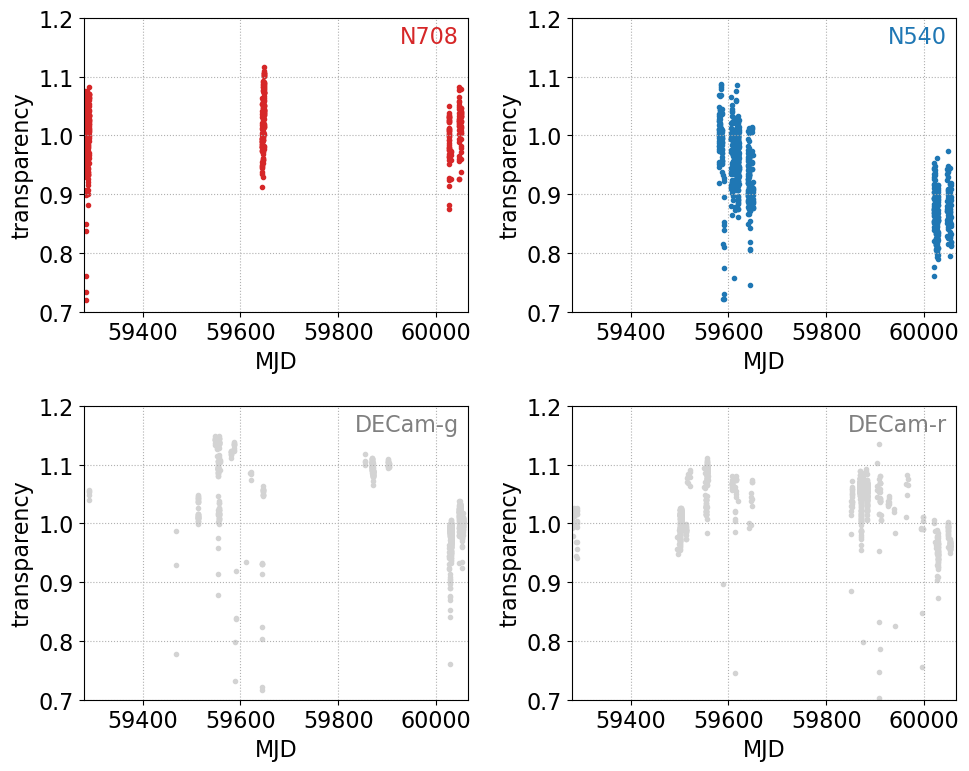

In [79]:
fig, axarr = plt.subplots(2,2,figsize=(10,8))
axarr = axarr.flatten()
axarr[1].scatter ( coo_o.merian_sidecar['mjd_obs'], coo_o.merian_sidecar['transparency'], color='tab:blue')
#axarr[0].scatter ( coo_o.merian_sidecar['mjd_obs'], coo_o.merian_sidecar['transparency'], color='tab:blue', s=1)

axarr[0].scatter ( coo_h.merian_sidecar['mjd_obs'], coo_h.merian_sidecar['transparency'], color='tab:red')

gmask = coo_o.sidecar['band'] == 'g'
axarr[2].scatter ( coo_o.sidecar.loc[gmask,'mjd_obs'], 
             coo_o.sidecar.loc[gmask,'transparency'],
             zorder=-10,
            color='lightgrey'
        )
gmask = coo_o.sidecar['band'] == 'r'
axarr[3].scatter ( coo_o.sidecar.loc[gmask,'mjd_obs'], 
             coo_o.sidecar.loc[gmask,'transparency'],
             zorder=-10,
            color='lightgrey'
        )

for ax in axarr:
    ax.set_ylim(0.7,1.2)
    ax.set_xlabel('MJD')
    ax.set_ylabel('transparency')
    ax.set_xlim(xmin,xmax)
    ax.grid ( ls=':')
    
ek.text ( 0.975, 0.975, 'N708', color='tab:red', ax=axarr[0])
ek.text ( 0.975, 0.975, 'N540', color='tab:blue', ax=axarr[1])
ek.text ( 0.975, 0.975, 'DECam-g', color='grey', ax=axarr[2])
ek.text ( 0.975, 0.975, 'DECam-r', color='grey', ax=axarr[3])

plt.tight_layout ()
plt.savefig('/Users/kadofong/Downloads/transparency_vs_time.png')

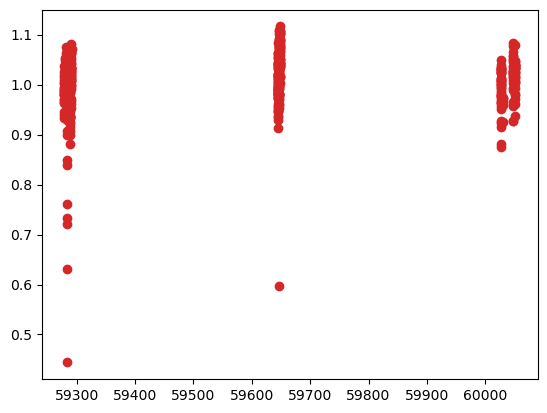